# Libraries

In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
from imutils.perspective import four_point_transform
from imutils import contours
sns.set()

# HQ Digital Reading

In [3]:
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 1, 0, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

In [97]:
# load the example image
#image = cv2.imread('Dataset/LQ_digital/1b6948b086f001d12a153572606f78744c006c24.jpg')
image = cv2.imread('Dataset/HQ_digital/28feeee4d7e52d0ba5d2cee31c8886e57f574319.jpg')
#image = cv2.imread('Dataset/HQ_digital/05e5e706f7654e756c1d4dc0740759f9559ab638.jpg')

In [98]:
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)

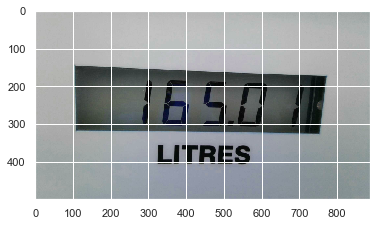

In [99]:
plt.imshow(image)

In [100]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
 
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        break

In [101]:
approx

array([[[105, 147]],

       [[110, 322]],

       [[754, 326]],

       [[771, 174]]], dtype=int32)

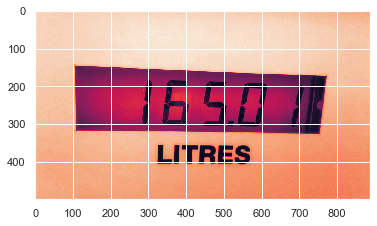

In [102]:
plt.imshow(gray)

In [103]:
# extract the thermostat display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

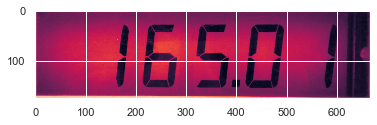

In [104]:
plt.imshow(warped)

In [105]:
img = cv2.medianBlur(warped,5)

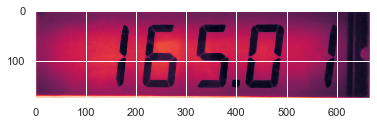

In [106]:
plt.imshow(img)

In [107]:
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,15,3)

Website for above function "adaptiveThreshold" : https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

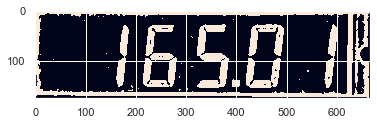

In [108]:
plt.imshow(th2)

In [109]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))

In [110]:
#Opening is just another name of erosion followed by dilation. It is useful in removing noise. 
thresh_opening = cv2.morphologyEx(th2, cv2.MORPH_OPEN, kernel, iterations = 1)

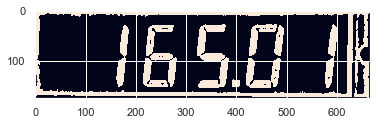

In [111]:
plt.imshow(thresh_opening)

In [112]:
#Closing is reverse of Opening, Dilation followed by Erosion. 
#It is useful in closing small holes inside the foreground objects, or small black points on the object.
thresh_closing = cv2.morphologyEx(thresh_opening, cv2.MORPH_CLOSE, kernel, iterations = 1)

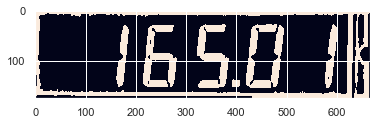

In [113]:
plt.imshow(thresh_closing)

In [126]:
dilation = cv2.dilate(thresh_closing, kernel, iterations = 1)

In [138]:
dilation

array([[  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0]], dtype=uint8)

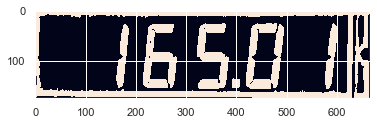

In [127]:
plt.imshow(dilation)

Comprendre les fonctions ci-dessus : https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

In [145]:
# find contours in the thresholded image, then initialize the digit contours lists
cnts = cv2.findContours(dilation.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# play with the contours : https://docs.opencv.org/3.4/d9/d8b/tutorial_py_contours_hierarchy.html
cnts = imutils.grab_contours(cnts)
digitCnts = []
Cadre = []

# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    
    print(w, '    ', h)
 
    #if the contour is sufficiently large, it must be a digit
    if (w >= 15 and w <= 80) and (h >= 15 and h <= 135) :
    #if (w >= 15 and w <= 80) and (h >= 15 and h <= 170) :
    #if (w >= 15) and (h >= 15 and h <= 170) :
    #Edit the parameters above
        digitCnts.append(c)
    if w > 600 :
        Cadre.append(c)

666      175
18      67
1      9
15      65
620      159
1      9
17      20
25      129
3      3
3      4
24      128
26      132
4      5
63      132
7      8
63      131
3      3
3      3
4      4
68      130
5      5
3      3
7      9
5      5
3      3
6      4


In [146]:
Cadre

[array([[[  1,   0]],
 
        [[  1, 126]],
 
        [[  2, 127]],
 
        [[  2, 130]],
 
        [[  3, 131]],
 
        [[  3, 139]],
 
        [[  4, 140]],
 
        [[  4, 147]],
 
        [[  2, 149]],
 
        [[  2, 160]],
 
        [[  1, 161]],
 
        [[  1, 162]],
 
        [[  0, 163]],
 
        [[  0, 172]],
 
        [[  2, 172]],
 
        [[  3, 171]],
 
        [[ 37, 171]],
 
        [[ 38, 172]],
 
        [[ 43, 172]],
 
        [[ 44, 171]],
 
        [[ 71, 171]],
 
        [[ 72, 172]],
 
        [[ 75, 172]],
 
        [[ 76, 171]],
 
        [[ 78, 171]],
 
        [[ 79, 172]],
 
        [[288, 172]],
 
        [[289, 173]],
 
        [[430, 173]],
 
        [[431, 174]],
 
        [[630, 174]],
 
        [[630, 163]],
 
        [[629, 162]],
 
        [[629, 159]],
 
        [[630, 158]],
 
        [[630, 107]],
 
        [[631, 106]],
 
        [[631,  32]],
 
        [[632,  31]],
 
        [[632,  12]],
 
        [[633,  11]],
 
        [[633,  

In [161]:
dilation

array([[  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255,   0]], dtype=uint8)

In [134]:
#image_contours = cv2.drawContours(output.copy(), digitCnts, -1, (0, 255, 0), 3)
#image_contours = cv2.drawContours(output.copy(), digitCnts, -1, (0, 255, 0), 3)
image_contours = cv2.drawContours(output.copy(), Cadre, -1, (0, 255, 0), 3)

In [135]:
cv2.imshow("Image_contours", image_contours)
cv2.imshow("Output", dilation)
cv2.waitKey(0)

-1

In [119]:
# sort the contours from left-to-right, then initialize the actual digits themselves
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
digits = []

In [120]:
len(digitCnts)

9

In [27]:
# loop over each of the digits
for c in digitCnts:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y + h, x:x + w]

    # compute the width and height of each of the 7 segments we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)

    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)), # top
        ((0, 0), (dW, h // 2)), # top-left
        ((w - dW, 0), (w, h // 2)), # top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)), # bottom-left
        ((w - dW, h // 2), (w, h)), # bottom-right
        ((0, h - dH), (w, h)) # bottom
    ]
    on = [0] * len(segments)
    # loop over the segments
    image_contours_seg = cv2.rectangle(output.copy(), (x, y), (x + w, y + h), (0, 255, 0), 1)
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
 
        # if the total number of non-zero pixels is greater than 50% of the area, mark the segment as "on"
        if total / float(area) > 0.5:
            on[i]= 1
 
    # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    # à décommenter
    #cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

NameError: name 'thresh' is not defined

In [ ]:
cv2.imshow("Output", output)
cv2.waitKey(0)

In [ ]:
image_contours = cv2.drawContours(output.copy(), digitCnts, -1, (0, 255, 0), 3)

In [ ]:
segments

In [ ]:
digitCnts

In [ ]:
# display the digits
#print(u"{}{}.{} ".format(*digits))
cv2.imshow("Input", image_contours)
cv2.imshow("Output", thresh)
cv2.waitKey(0)